In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# hyperparams
in_chan = 1
hidden_ch = 64
out_ch = 1
device = torch.device('cuda')
n_epochs = 10
batch_size = 128
device

device(type='cuda')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

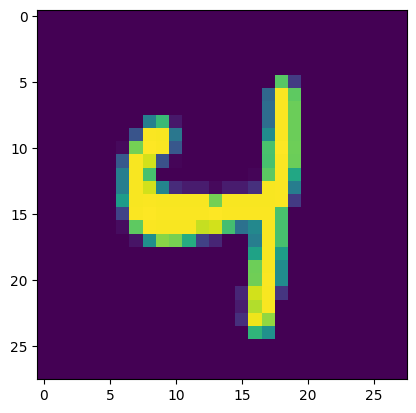

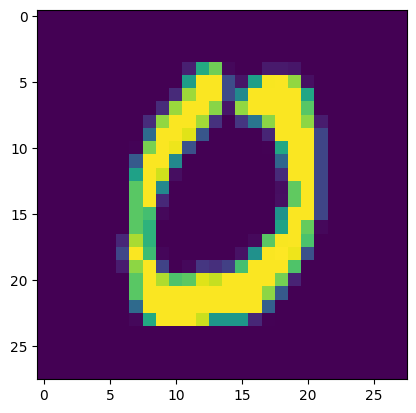

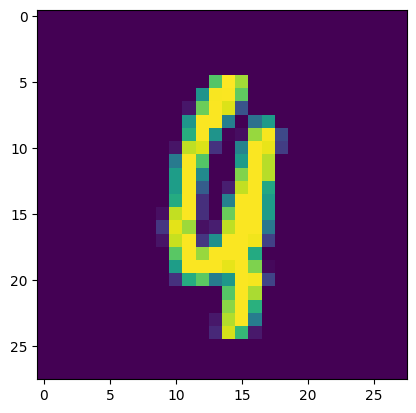

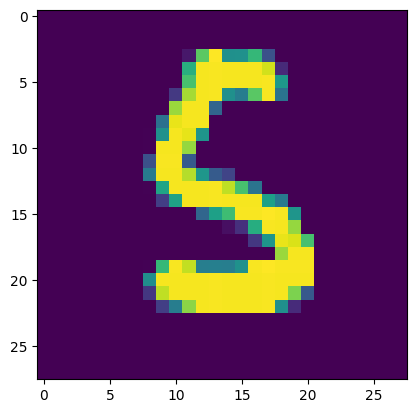

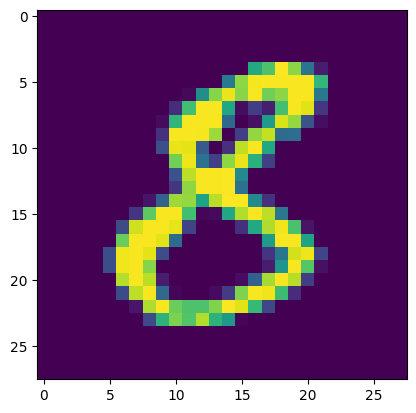

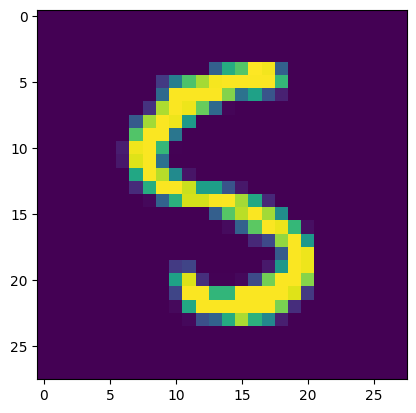

In [4]:
import matplotlib.pyplot as plt

for img_id in range(1230, 1236):
    plt.imshow(dataset_test.data[img_id].detach().numpy())
    plt.show() # ЧЕТЫРЕ

In [135]:
# VAE

# 28x28 -> 7x7
class Encoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, latent_ch=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=2, 
                           padding=2) # 28x28 -> 14x14 //10x10?
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.pool = nn.MaxPool2d(2, 2) # 7x7 // 5x5?
    self.conv_mu = nn.Conv2d(hidden_ch, latent_ch, kernel_size=3, padding=1)
    self.conv_sigma = nn.Conv2d(hidden_ch, latent_ch, kernel_size=3, padding=1)

    self.do1 = nn.Dropout(0.1)
    self.do2 = nn.Dropout(0.1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(self.do1(self.activ(self.bn1(x))))
    x = self.pool(self.do2(self.activ(self.bn2(x))))
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))

    return mu, sigma

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, output_ch, hidden_ch, latent_ch=1):
    super().__init__()
    self.conv1 = nn.Conv2d(latent_ch, hidden_ch, kernel_size=3, padding=1)
    self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.convtrans = nn.ConvTranspose2d(hidden_ch, int(hidden_ch/(hidden_ch/2)), kernel_size=6, 
                                    stride=2, padding=4)
    self.convtrans2 = nn.ConvTranspose2d(int(hidden_ch/(hidden_ch/2)), int(hidden_ch/(hidden_ch)), kernel_size=5,
                                    stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(hidden_ch)

    self.do1 = nn.Dropout(0.1)
    self.do2 = nn.Dropout(0.1)
    self.do3 = nn.Dropout(0.1)
    self.do4 = nn.Dropout(0.1)
    self.do5 = nn.Dropout(0.1)
    self.do6 = nn.Dropout(0.1)
    self.activ = nn.Tanh()

  def forward(self, x):
    x = self.conv1(x) 
    x = self.conv2((self.do1(self.activ(x))))
    x = self.convtrans(self.upsample(self.do2(self.activ(x))))
    x = self.convtrans2(self.do3(self.activ(x)))
    # x = self.convtrans3(self.do4(self.activ(x)))
    # x = self.convtrans4(self.do5(self.activ(x)))

    return x

def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(mu), torch.ones_like(mu))

class VariationalAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, latent_ch=1):
    super().__init__()
    self.encoder = Encoder(input_ch, hidden_ch, latent_ch)
    self.decoder = Decoder(input_ch, hidden_ch, latent_ch)

  def forward(self, x):
    mu, sigma = self.encoder(x)
    x = sampling(mu, sigma)
    x = self.decoder(x)

    return x, mu, sigma

epoch: 0, step: 0, tot_loss: 1.3438575267791748, loss: 1.1606911420822144, kl_loss: 0.6105544567108154
epoch: 0, step: 200, tot_loss: 0.3185924291610718, loss: 0.2642430365085602, kl_loss: 0.1811646819114685
epoch: 0, step: 400, tot_loss: 0.28068697452545166, loss: 0.22970187664031982, kl_loss: 0.16995029151439667


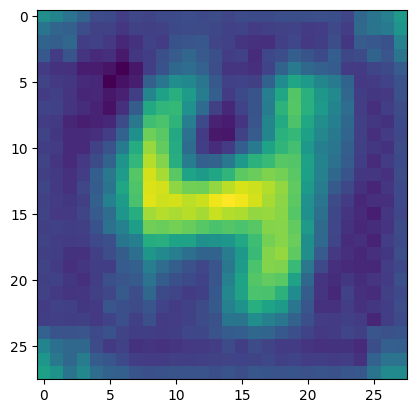

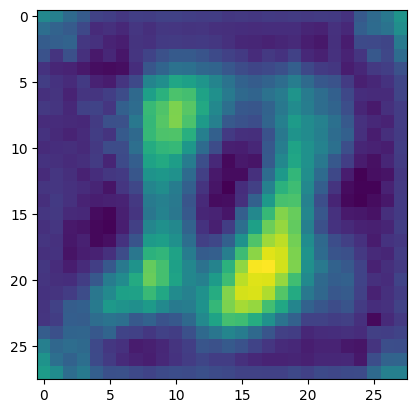

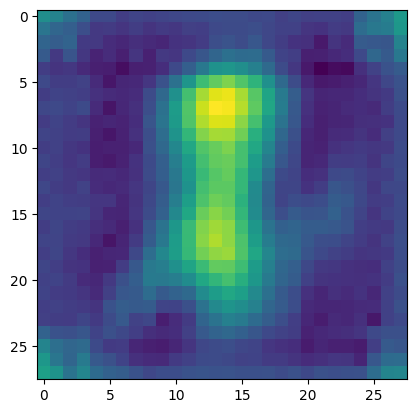

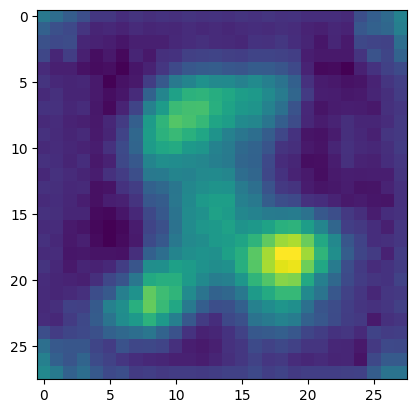

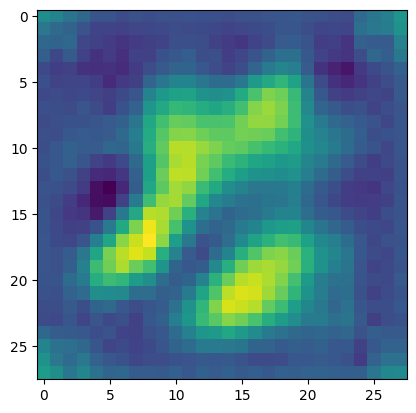

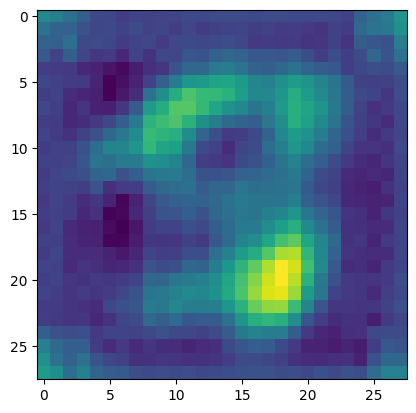

epoch: 1, step: 0, tot_loss: 0.28538981080055237, loss: 0.23353910446166992, kl_loss: 0.17283567786216736
epoch: 1, step: 200, tot_loss: 0.2758543789386749, loss: 0.2217135727405548, kl_loss: 0.18046934902668
epoch: 1, step: 400, tot_loss: 0.2687636613845825, loss: 0.21361567080020905, kl_loss: 0.18382662534713745


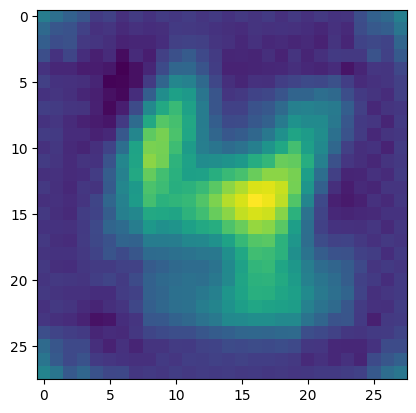

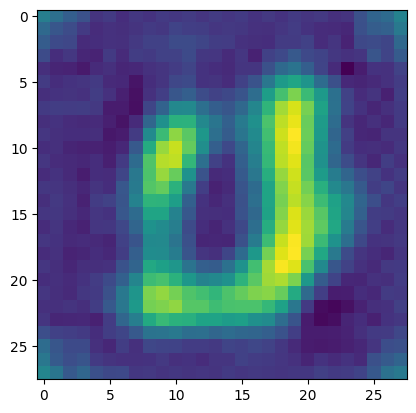

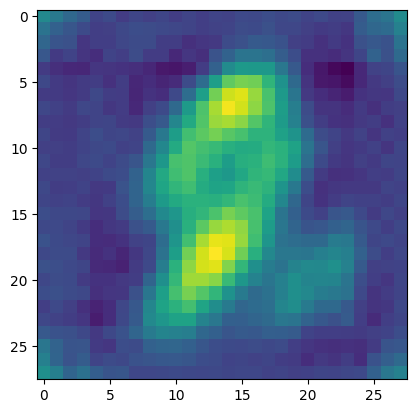

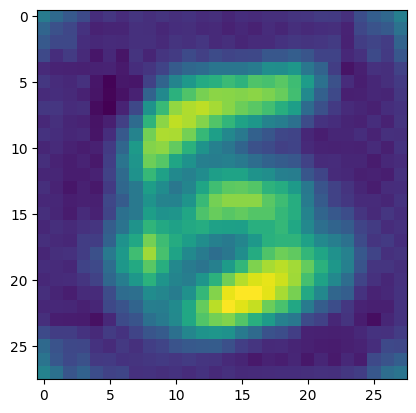

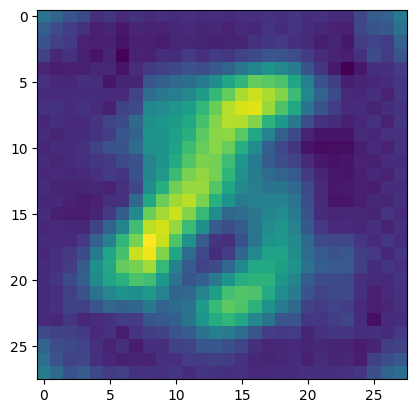

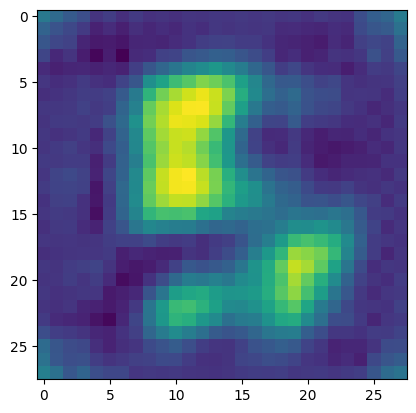

epoch: 2, step: 0, tot_loss: 0.2664078176021576, loss: 0.20500914752483368, kl_loss: 0.20466220378875732
epoch: 2, step: 200, tot_loss: 0.26376214623451233, loss: 0.2060149610042572, kl_loss: 0.19249065220355988
epoch: 2, step: 400, tot_loss: 0.2542945146560669, loss: 0.19311055541038513, kl_loss: 0.2039465606212616


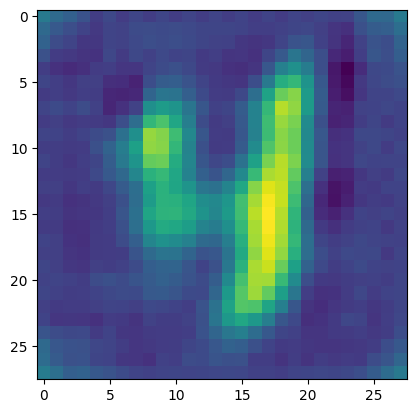

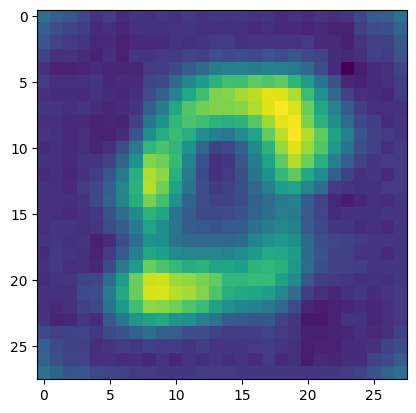

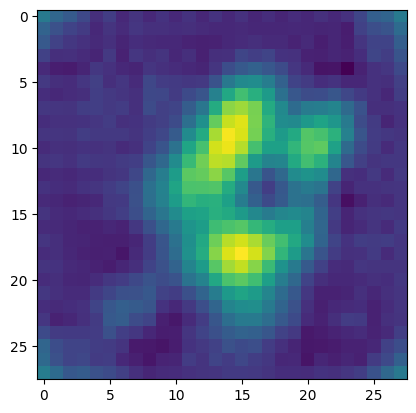

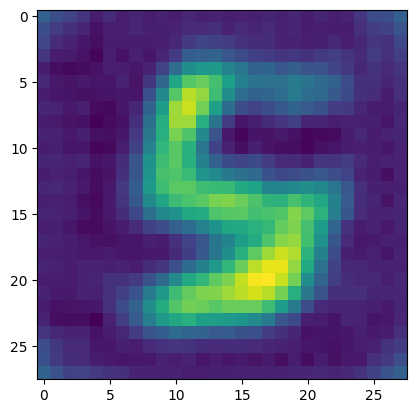

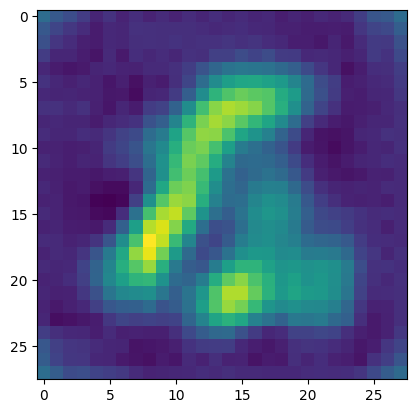

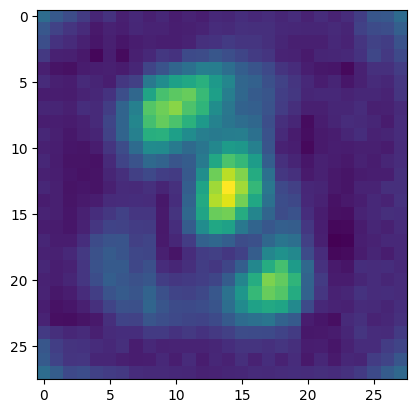

epoch: 3, step: 0, tot_loss: 0.25173434615135193, loss: 0.19496726989746094, kl_loss: 0.1892235428094864
epoch: 3, step: 200, tot_loss: 0.25373849272727966, loss: 0.19476555287837982, kl_loss: 0.19657643139362335
epoch: 3, step: 400, tot_loss: 0.2525733411312103, loss: 0.19099488854408264, kl_loss: 0.20526151359081268


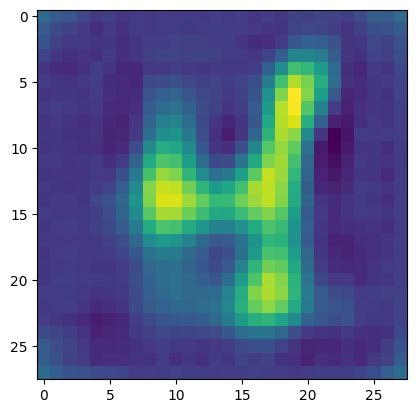

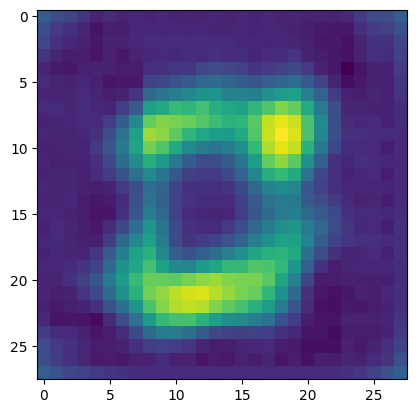

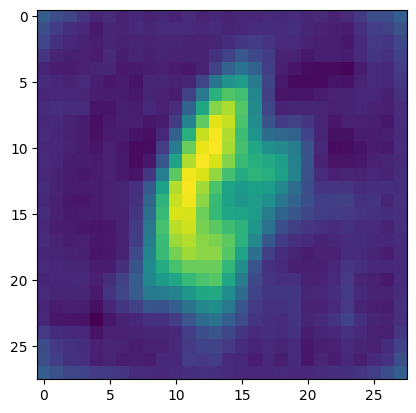

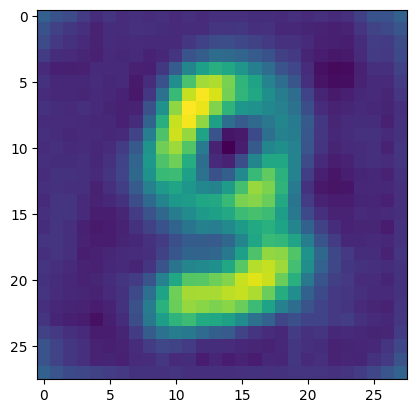

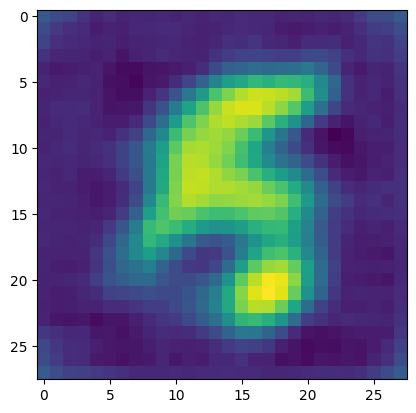

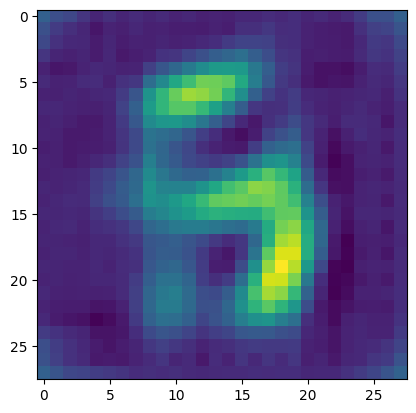

epoch: 4, step: 0, tot_loss: 0.2465801239013672, loss: 0.17814865708351135, kl_loss: 0.2281048446893692
epoch: 4, step: 200, tot_loss: 0.23931273818016052, loss: 0.1764371395111084, kl_loss: 0.20958533883094788
epoch: 4, step: 400, tot_loss: 0.25599589943885803, loss: 0.19131281971931458, kl_loss: 0.21561022102832794


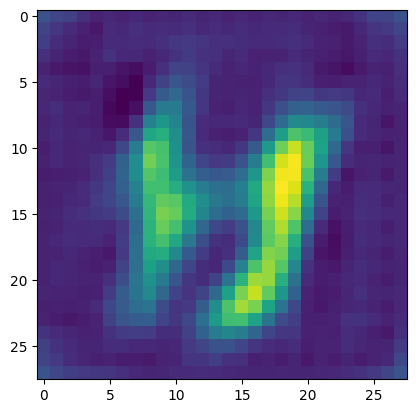

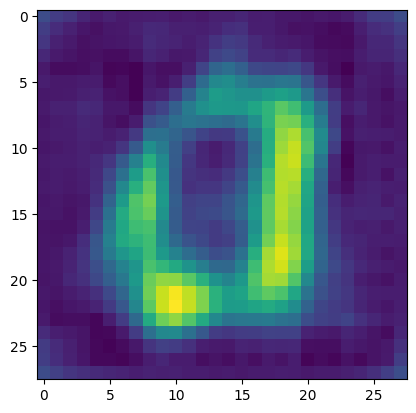

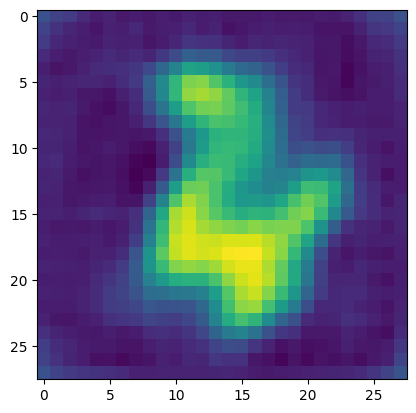

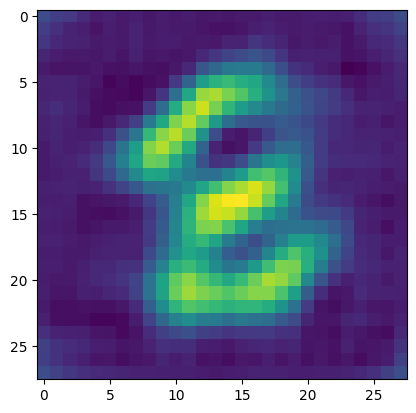

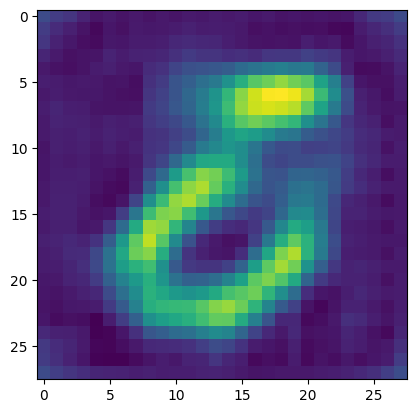

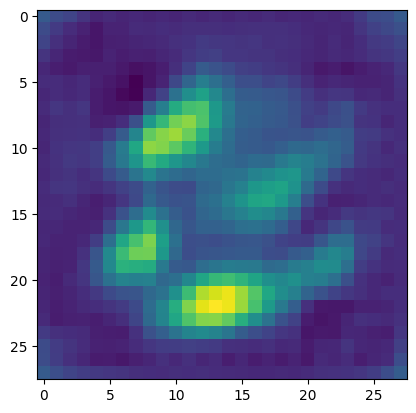

epoch: 5, step: 0, tot_loss: 0.24594083428382874, loss: 0.18376058340072632, kl_loss: 0.20726747810840607
epoch: 5, step: 200, tot_loss: 0.24614255130290985, loss: 0.18091385066509247, kl_loss: 0.21742898225784302
epoch: 5, step: 400, tot_loss: 0.2442513108253479, loss: 0.1773763746023178, kl_loss: 0.22291642427444458


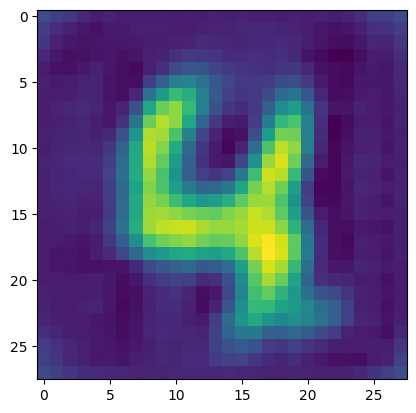

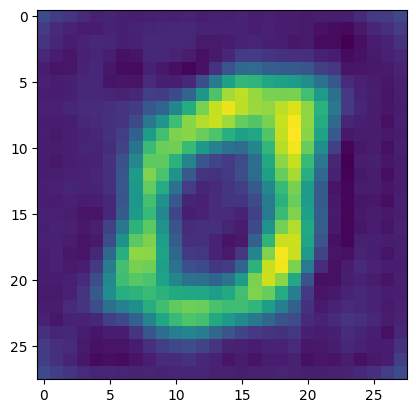

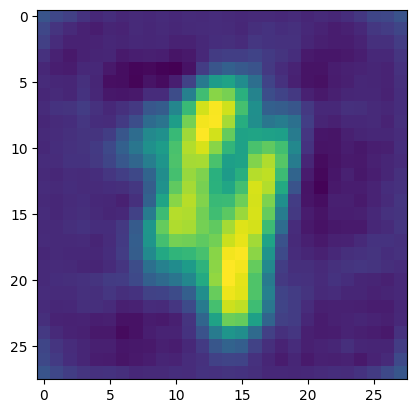

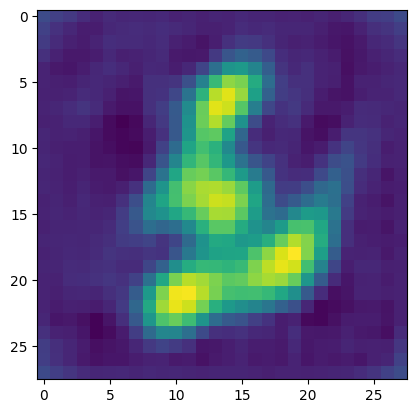

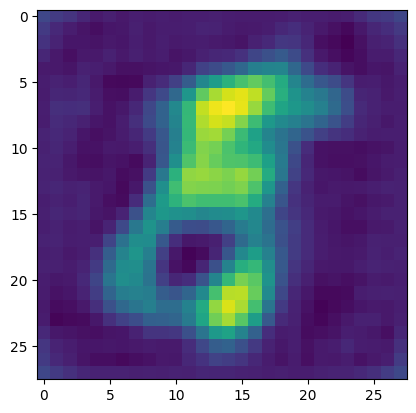

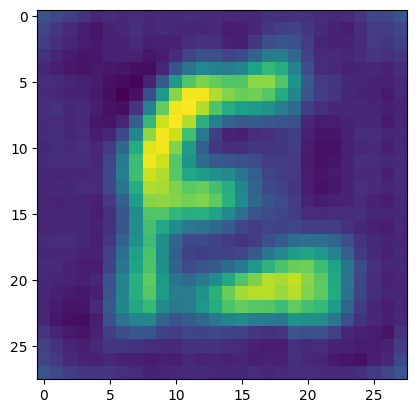

epoch: 6, step: 0, tot_loss: 0.23994696140289307, loss: 0.174655020236969, kl_loss: 0.21763978898525238
epoch: 6, step: 200, tot_loss: 0.2432262897491455, loss: 0.1759069412946701, kl_loss: 0.22439780831336975
epoch: 6, step: 400, tot_loss: 0.24061113595962524, loss: 0.1720527857542038, kl_loss: 0.22852784395217896


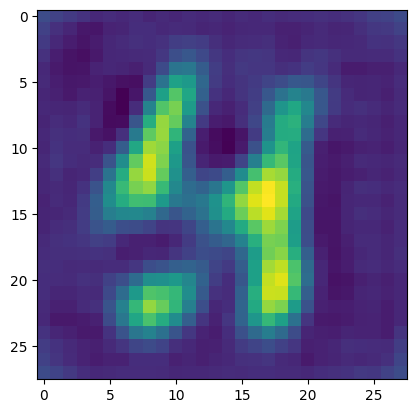

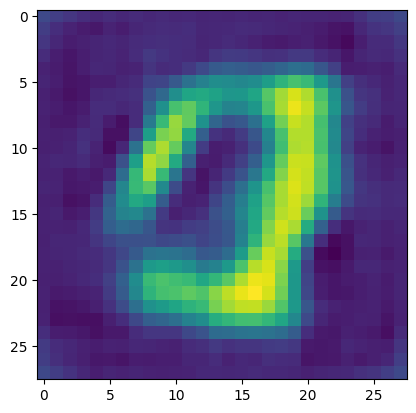

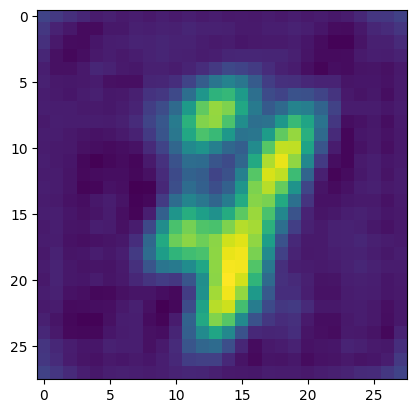

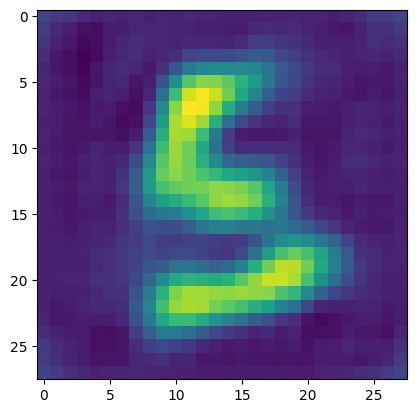

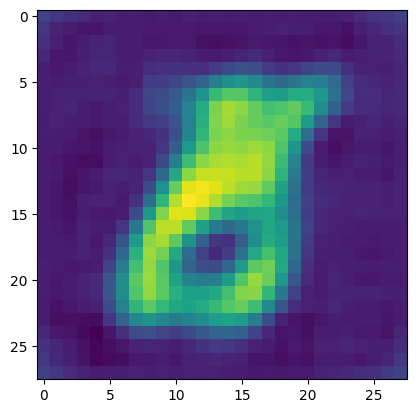

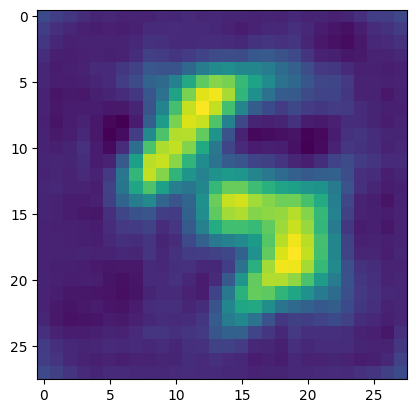

epoch: 7, step: 0, tot_loss: 0.23655299842357635, loss: 0.1738257110118866, kl_loss: 0.2090909481048584
epoch: 7, step: 200, tot_loss: 0.242899090051651, loss: 0.17637279629707336, kl_loss: 0.2217542827129364
epoch: 7, step: 400, tot_loss: 0.22975003719329834, loss: 0.16393941640853882, kl_loss: 0.21936875581741333


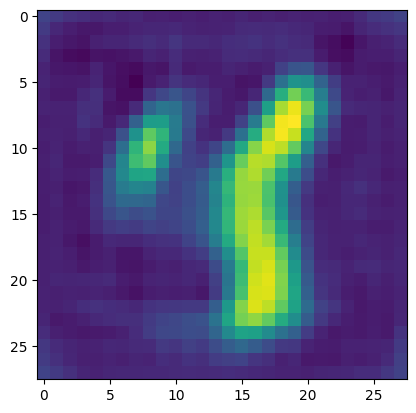

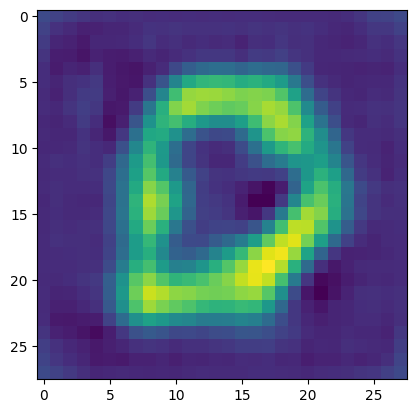

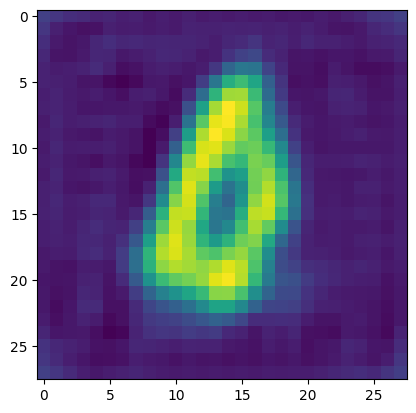

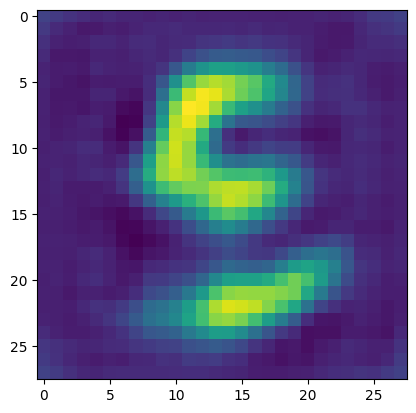

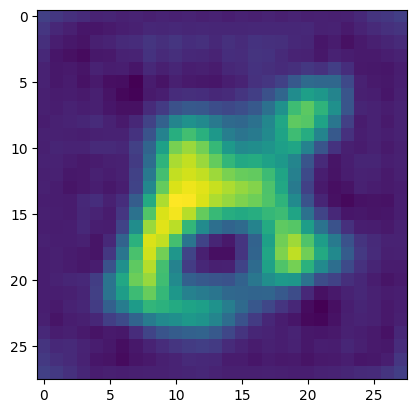

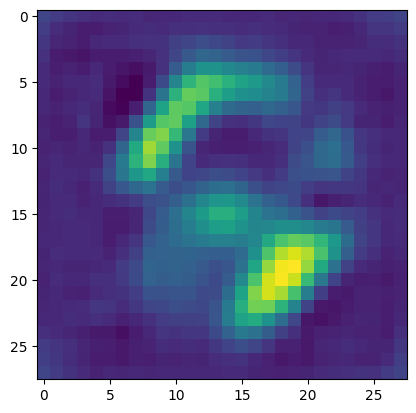

epoch: 8, step: 0, tot_loss: 0.23798833787441254, loss: 0.16997963190078735, kl_loss: 0.22669567167758942
epoch: 8, step: 200, tot_loss: 0.2319152057170868, loss: 0.1613171398639679, kl_loss: 0.2353268414735794
epoch: 8, step: 400, tot_loss: 0.23575574159622192, loss: 0.16926619410514832, kl_loss: 0.22163183987140656


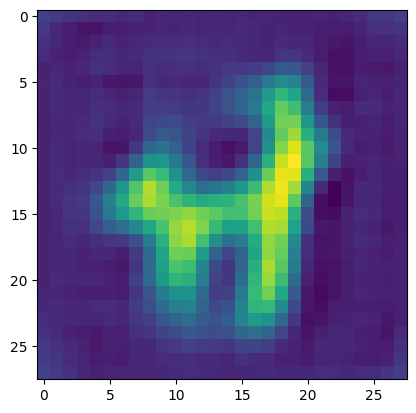

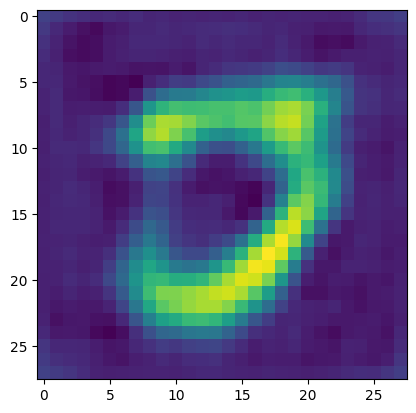

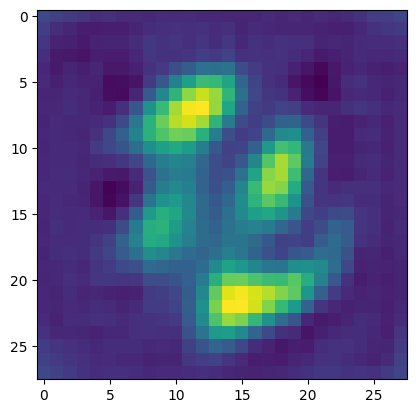

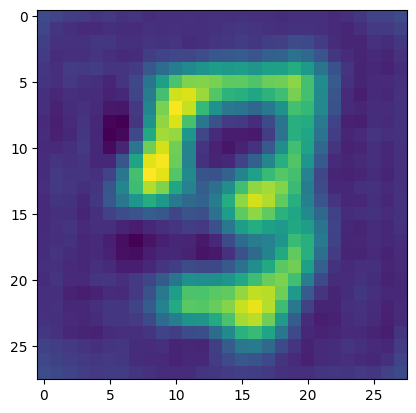

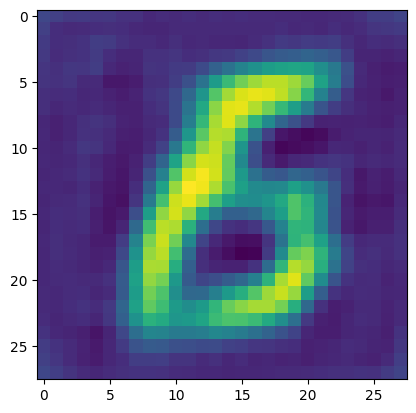

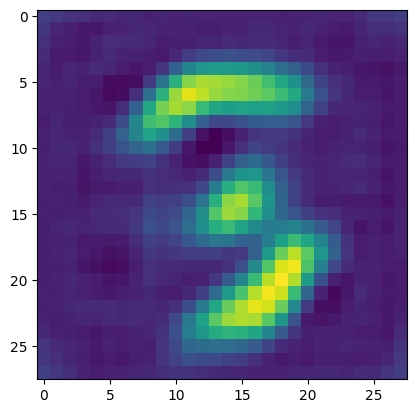

epoch: 9, step: 0, tot_loss: 0.2301260083913803, loss: 0.16476503014564514, kl_loss: 0.21786992251873016
epoch: 9, step: 200, tot_loss: 0.24067068099975586, loss: 0.1731339991092682, kl_loss: 0.22512222826480865
epoch: 9, step: 400, tot_loss: 0.23121604323387146, loss: 0.16456492245197296, kl_loss: 0.2221704125404358


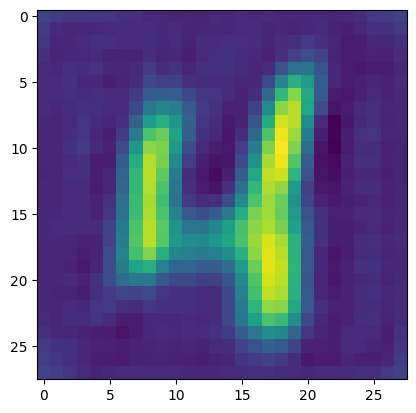

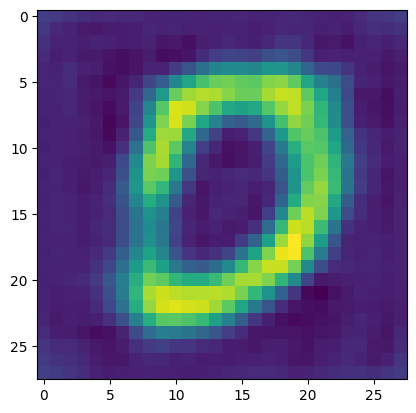

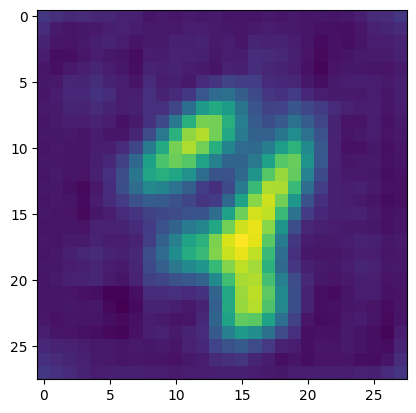

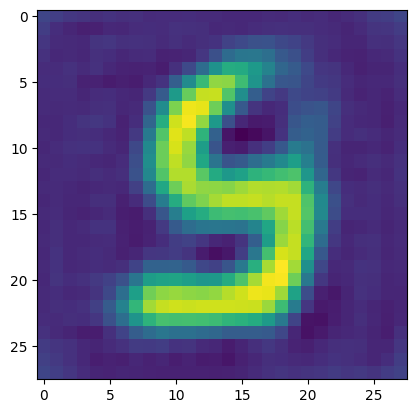

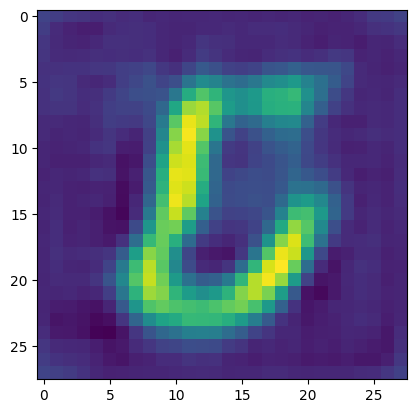

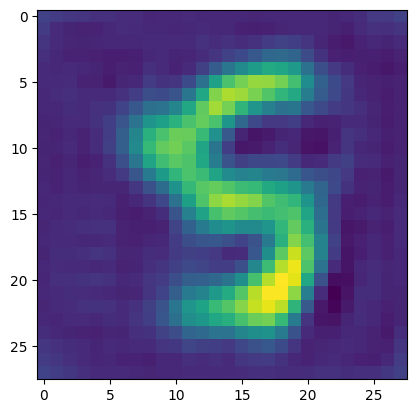

epoch: 10, step: 0, tot_loss: 0.23735558986663818, loss: 0.16940048336982727, kl_loss: 0.226516991853714
epoch: 10, step: 200, tot_loss: 0.2338484525680542, loss: 0.16452080011367798, kl_loss: 0.2310921996831894
epoch: 10, step: 400, tot_loss: 0.2340066134929657, loss: 0.16755758225917816, kl_loss: 0.22149677574634552


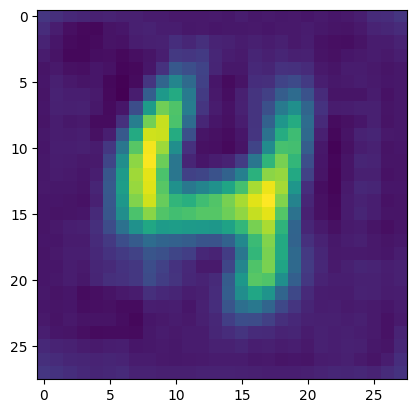

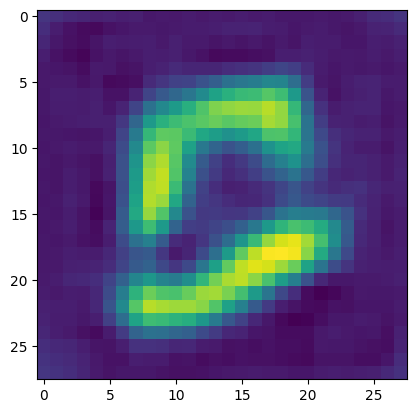

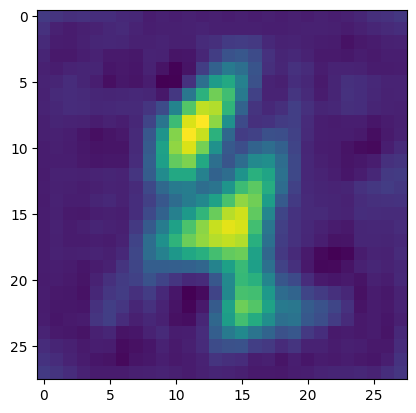

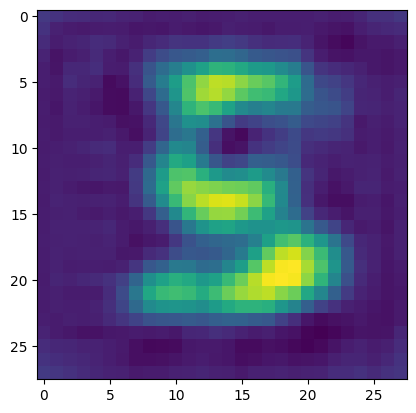

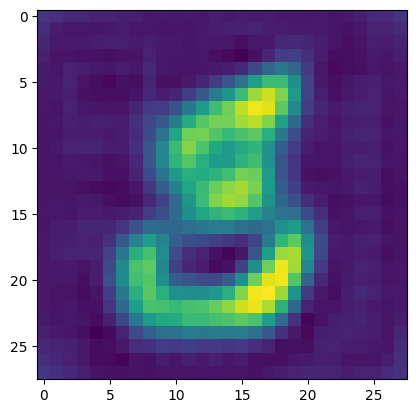

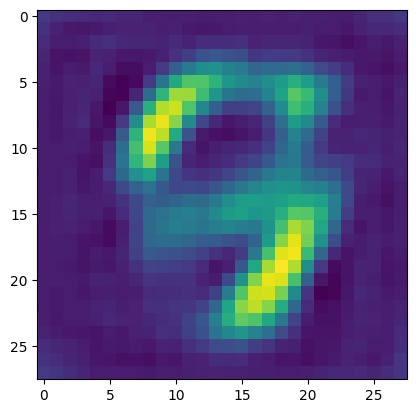

epoch: 11, step: 0, tot_loss: 0.23367111384868622, loss: 0.162858784198761, kl_loss: 0.2360410988330841
epoch: 11, step: 200, tot_loss: 0.23738810420036316, loss: 0.16812841594219208, kl_loss: 0.23086561262607574
epoch: 11, step: 400, tot_loss: 0.22864431142807007, loss: 0.16331903636455536, kl_loss: 0.2177508920431137


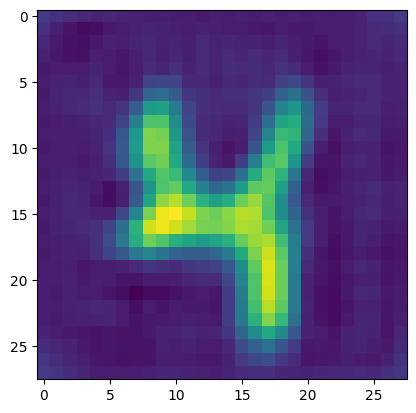

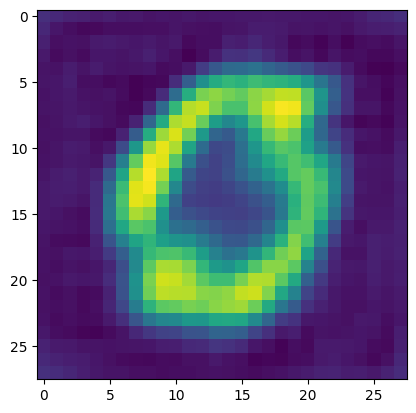

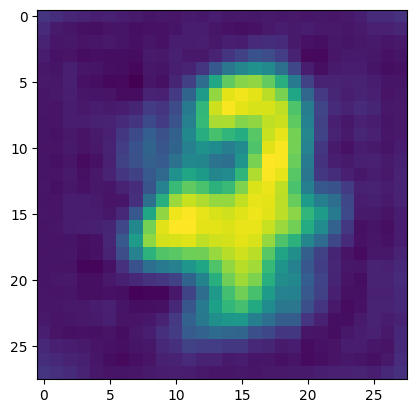

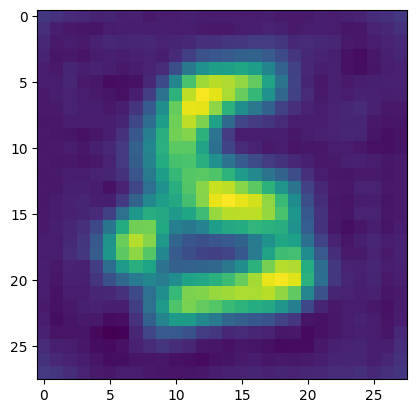

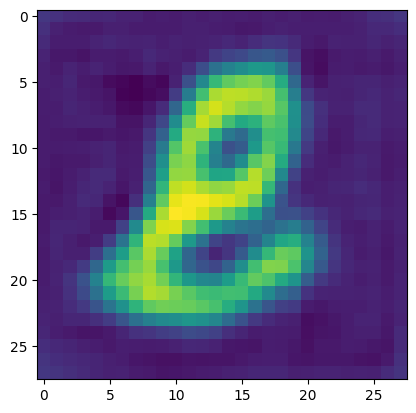

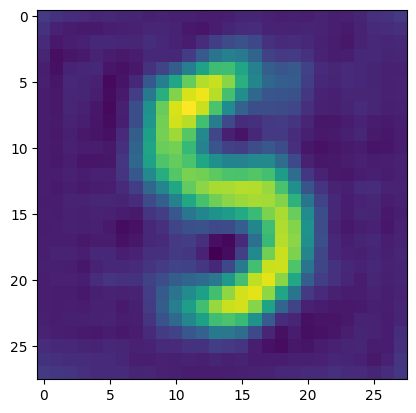

epoch: 12, step: 0, tot_loss: 0.22918644547462463, loss: 0.1630019098520279, kl_loss: 0.22061513364315033
epoch: 12, step: 200, tot_loss: 0.22869043052196503, loss: 0.15898241102695465, kl_loss: 0.23236005008220673
epoch: 12, step: 400, tot_loss: 0.2296230047941208, loss: 0.16176527738571167, kl_loss: 0.2261924147605896


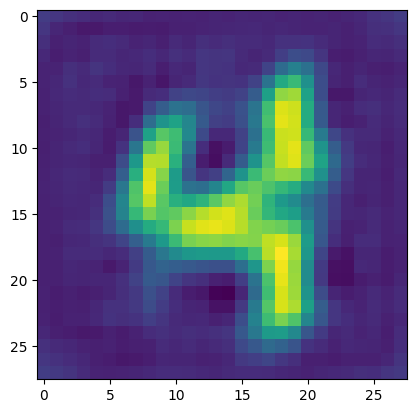

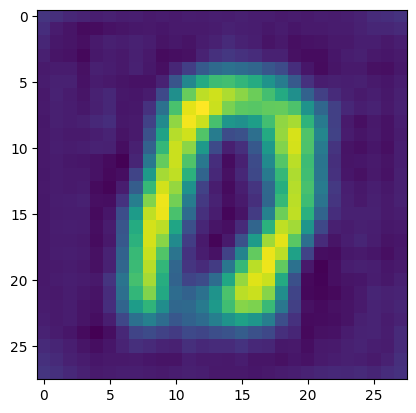

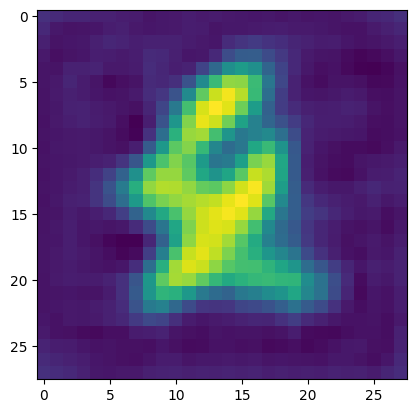

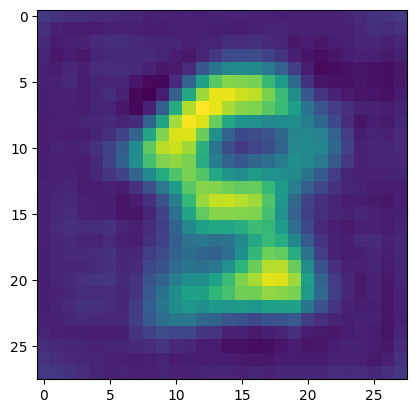

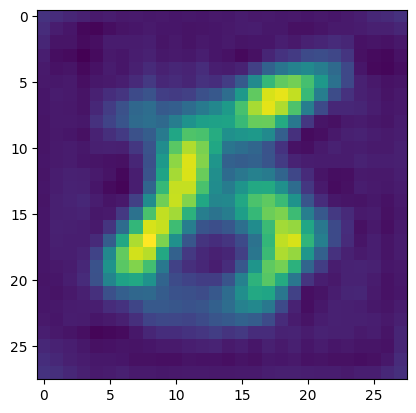

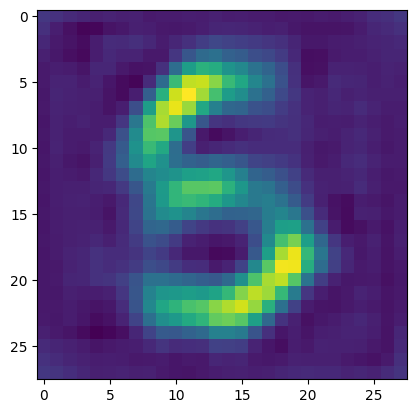

epoch: 13, step: 0, tot_loss: 0.2323947250843048, loss: 0.15959568321704865, kl_loss: 0.2426634430885315
epoch: 13, step: 200, tot_loss: 0.23973557353019714, loss: 0.16627910733222961, kl_loss: 0.2448548972606659
epoch: 13, step: 400, tot_loss: 0.2298719882965088, loss: 0.15971918404102325, kl_loss: 0.2338426560163498


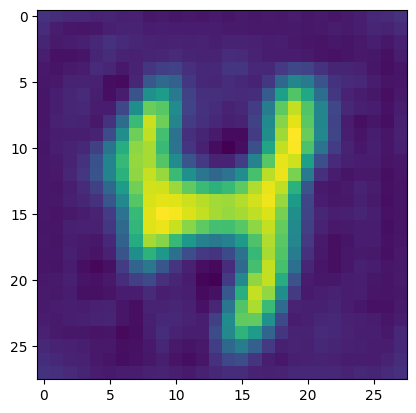

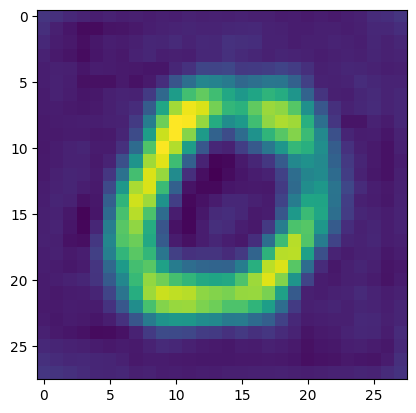

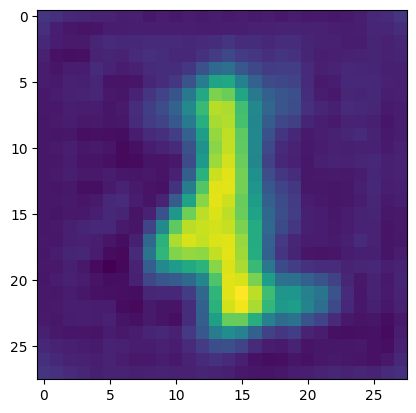

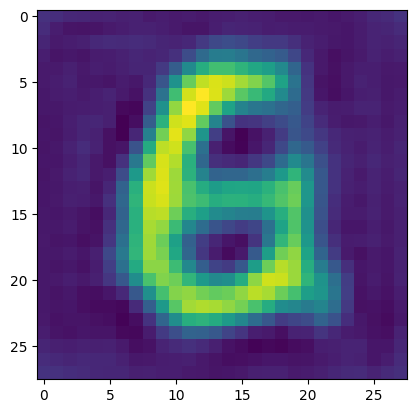

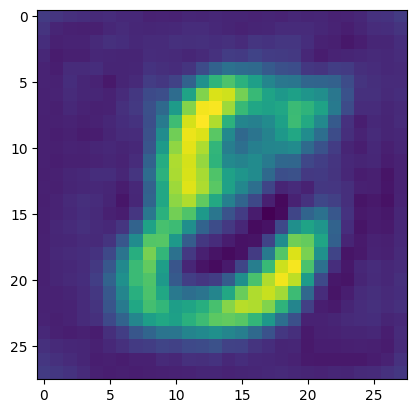

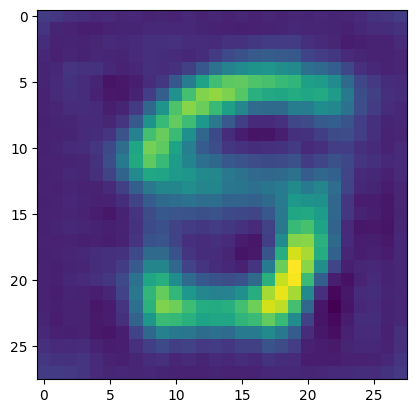

epoch: 14, step: 0, tot_loss: 0.2420097291469574, loss: 0.17407704889774323, kl_loss: 0.22644229233264923
epoch: 14, step: 200, tot_loss: 0.22755871713161469, loss: 0.15611381828784943, kl_loss: 0.23814965784549713
epoch: 14, step: 400, tot_loss: 0.23457154631614685, loss: 0.16637124121189117, kl_loss: 0.22733430564403534


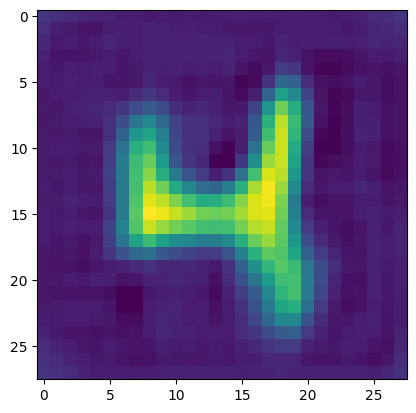

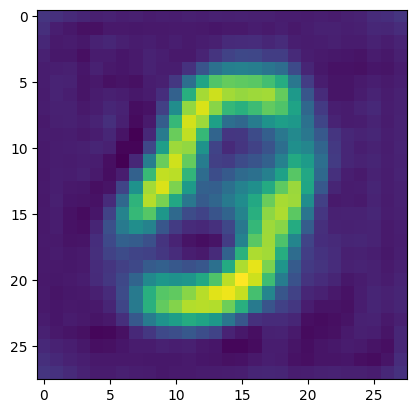

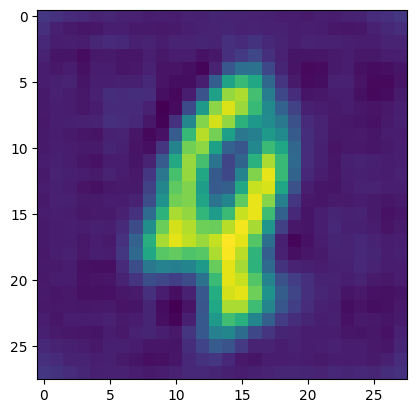

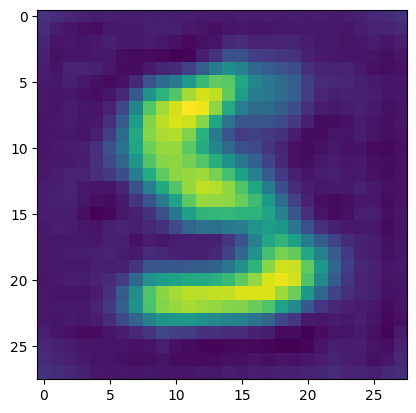

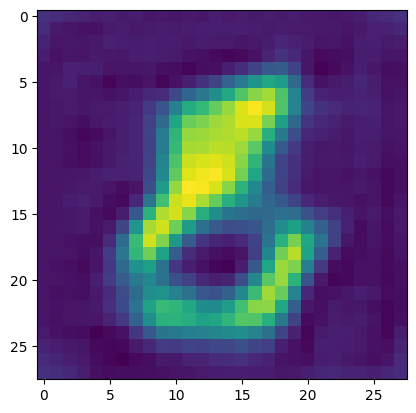

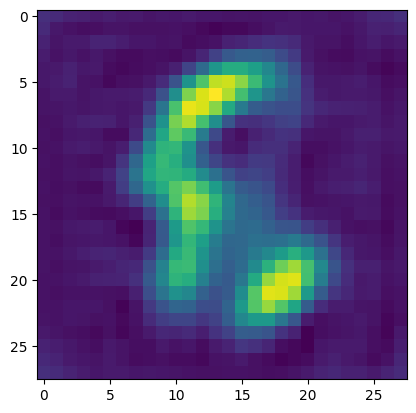

epoch: 15, step: 0, tot_loss: 0.2344563603401184, loss: 0.16063784062862396, kl_loss: 0.24606174230575562
epoch: 15, step: 200, tot_loss: 0.23742541670799255, loss: 0.16259898245334625, kl_loss: 0.2494214028120041
epoch: 15, step: 400, tot_loss: 0.2391105592250824, loss: 0.17156070470809937, kl_loss: 0.22516615688800812


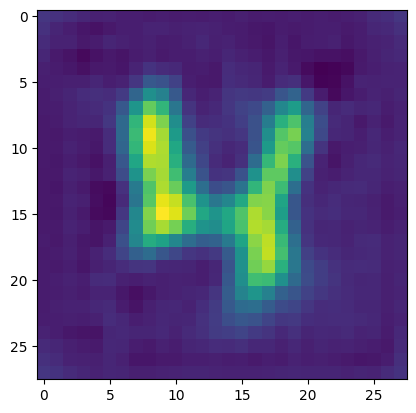

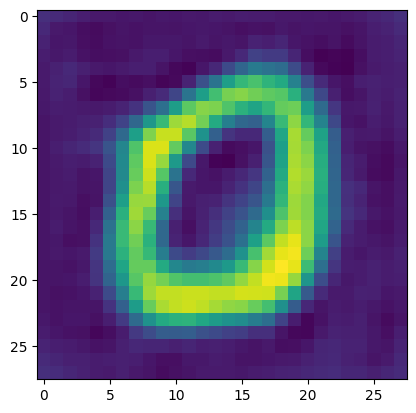

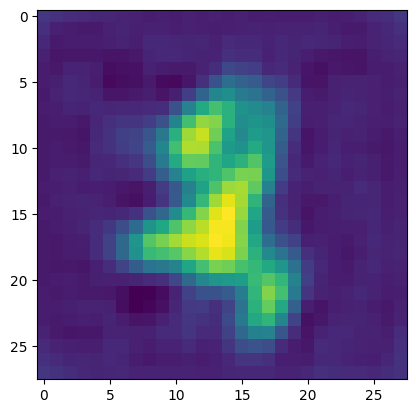

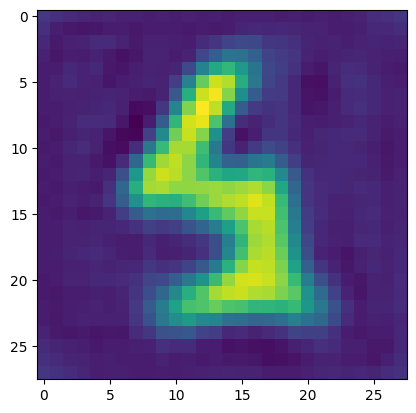

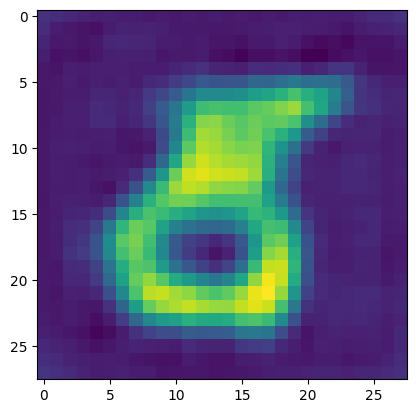

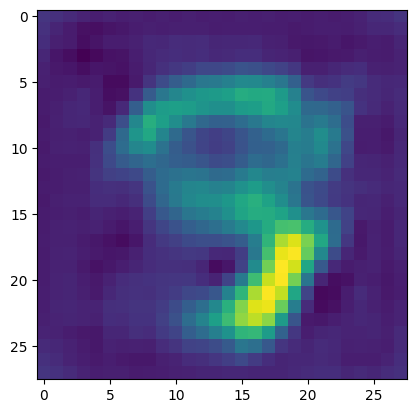

epoch: 16, step: 0, tot_loss: 0.2306271344423294, loss: 0.15904384851455688, kl_loss: 0.23861093819141388
epoch: 16, step: 200, tot_loss: 0.2272719442844391, loss: 0.15413925051689148, kl_loss: 0.2437756210565567
epoch: 16, step: 400, tot_loss: 0.23361250758171082, loss: 0.1662144660949707, kl_loss: 0.22466012835502625


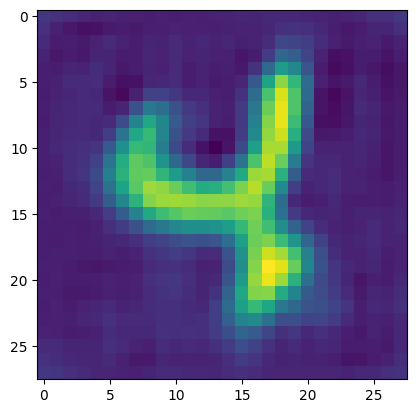

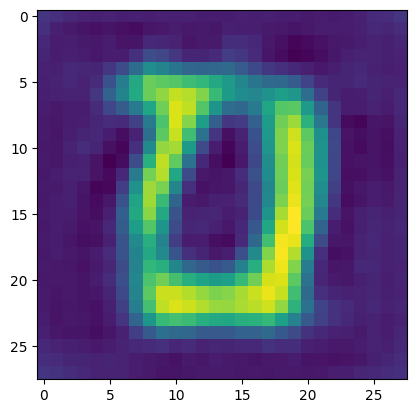

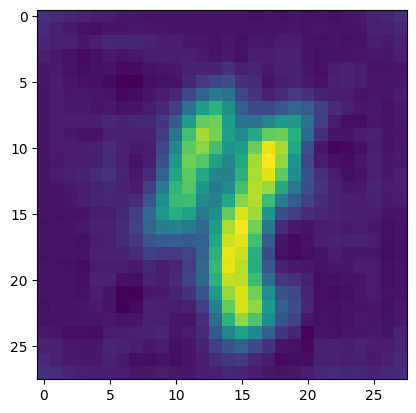

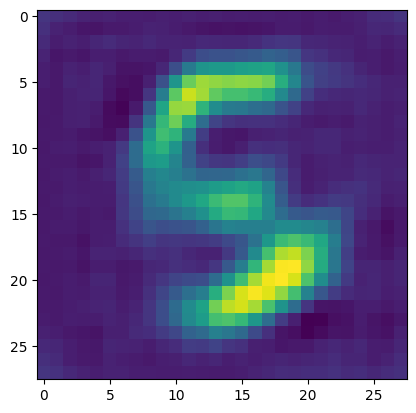

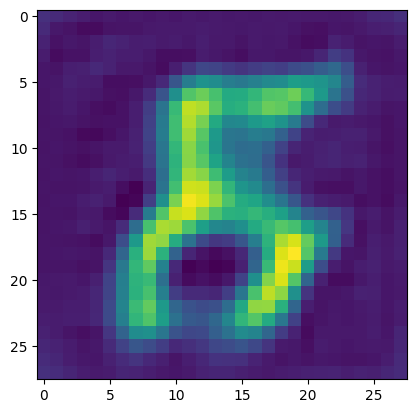

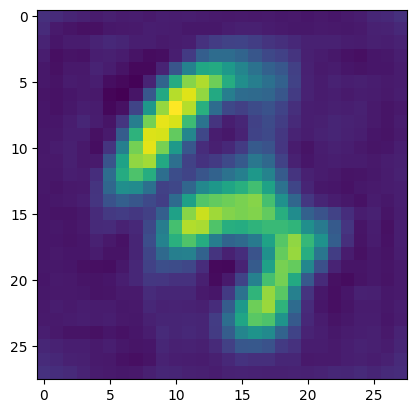

epoch: 17, step: 0, tot_loss: 0.23172959685325623, loss: 0.16324478387832642, kl_loss: 0.22828267514705658
epoch: 17, step: 200, tot_loss: 0.23047278821468353, loss: 0.15923376381397247, kl_loss: 0.23746341466903687
epoch: 17, step: 400, tot_loss: 0.23224148154258728, loss: 0.15998052060604095, kl_loss: 0.24086986482143402


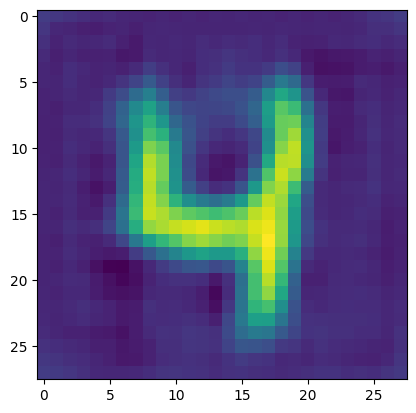

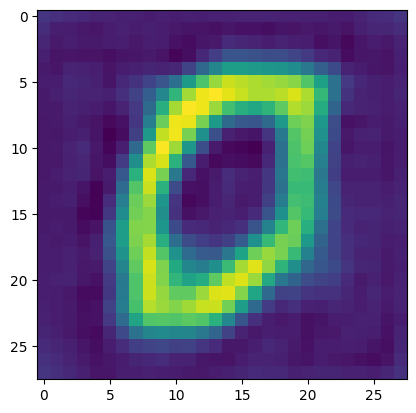

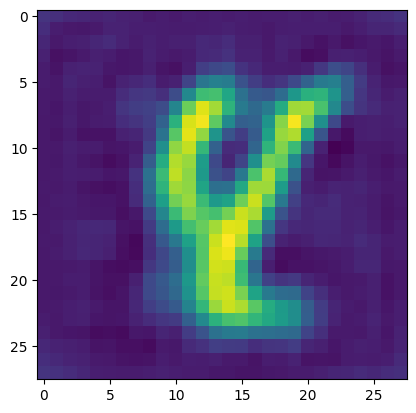

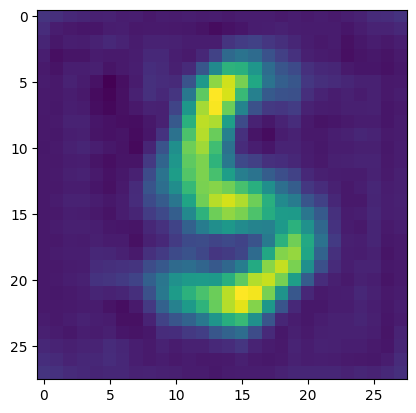

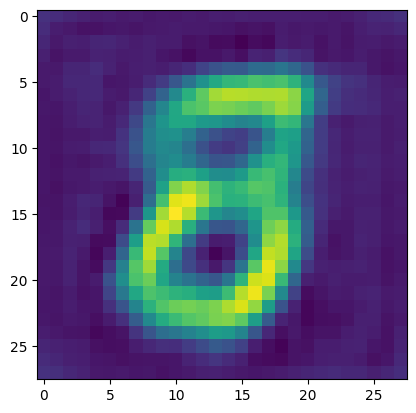

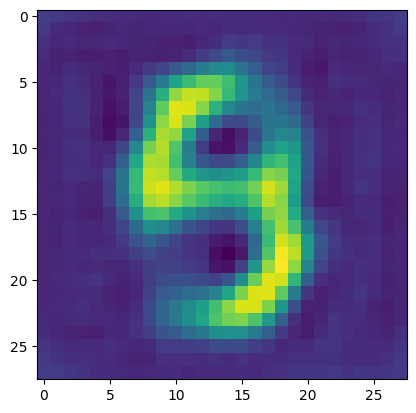

epoch: 18, step: 0, tot_loss: 0.22785282135009766, loss: 0.1596824824810028, kl_loss: 0.22723442316055298
epoch: 18, step: 200, tot_loss: 0.22942093014717102, loss: 0.15784110128879547, kl_loss: 0.23859943449497223
epoch: 18, step: 400, tot_loss: 0.23559090495109558, loss: 0.16429077088832855, kl_loss: 0.23766711354255676


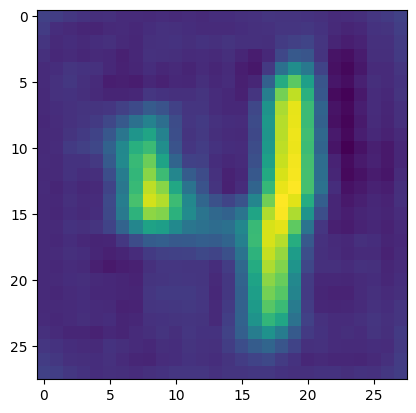

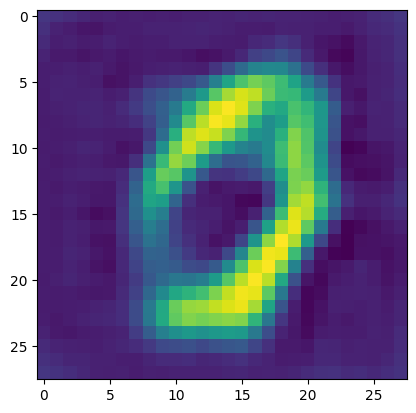

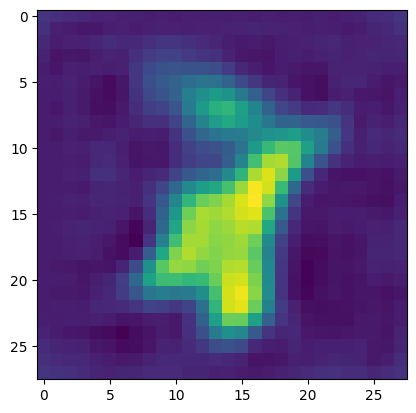

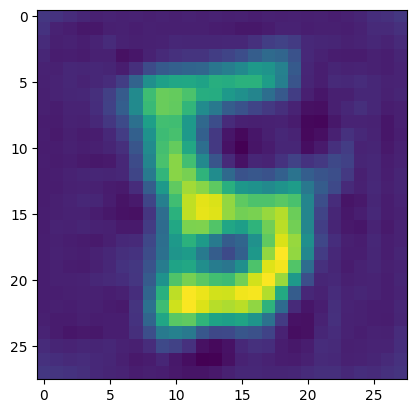

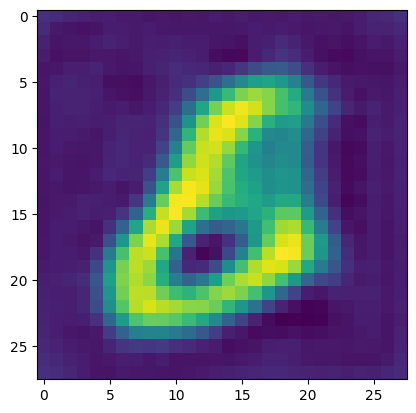

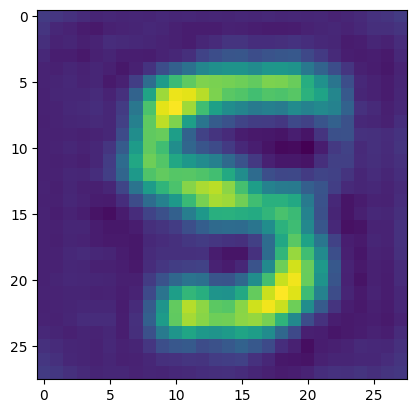

epoch: 19, step: 0, tot_loss: 0.22964632511138916, loss: 0.15944147109985352, kl_loss: 0.23401616513729095
epoch: 19, step: 200, tot_loss: 0.23449137806892395, loss: 0.16811484098434448, kl_loss: 0.2212551236152649
epoch: 19, step: 400, tot_loss: 0.23447969555854797, loss: 0.16081658005714417, kl_loss: 0.2455437332391739


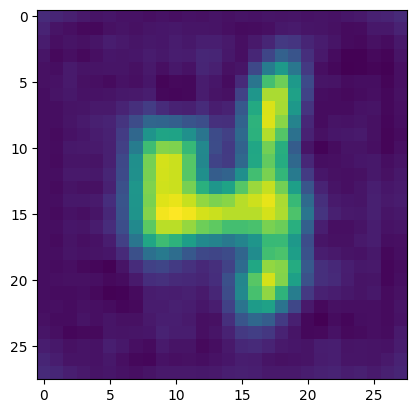

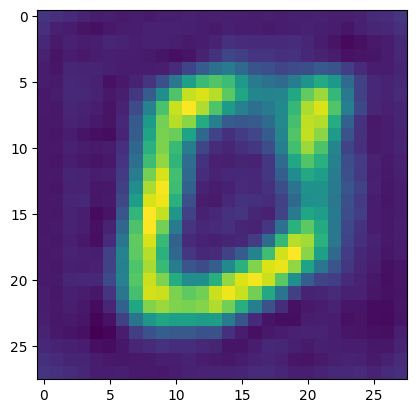

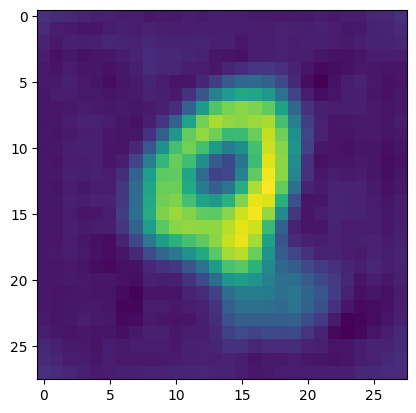

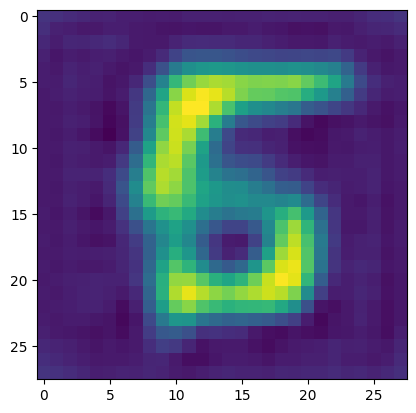

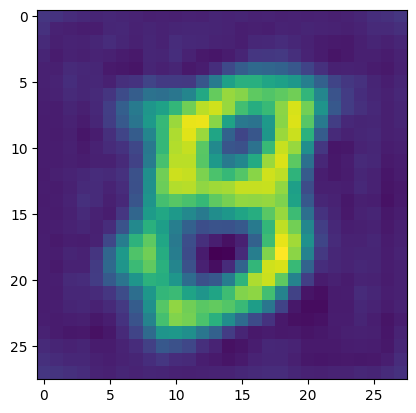

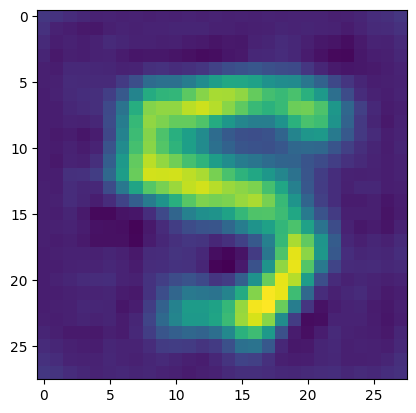

In [136]:
#denoise
input_ch = 1
hidden_ch = 64
model = VariationalAutoEncoder(input_ch, hidden_ch).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()
noise_factor = 0.5

def kl_loss_func(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))

    return torch.distributions.kl_divergence(p, q).mean()

for epoch in range(20):
    
    for i, batch in enumerate(trainloader):
        optim.zero_grad()
        data = batch[0].to(device)
        # noise = noise_factor * torch.normal(torch.zeros_like(data), torch.ones_like(data))
        predict, mu, sigma = model(data)
        kl_loss = kl_loss_func(mu, sigma)
        loss = loss_func(predict, data)
        tot_loss = loss + 0.3 * kl_loss
        tot_loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, tot_loss: {tot_loss.item()}, '
            f'loss: {loss.item()}, kl_loss: {kl_loss.item()}')
    model.eval()
    with torch.no_grad():
        for img_id in range(1230, 1236):
            item = dataset_test[img_id][0].view(1, 1, 28, 28).to(device)
            # noise_item = item + noise_factor * torch.normal(torch.zeros_like(item), torch.ones_like(item))
            # plt.imshow(noise_item.view(28, 28).cpu().detach().numpy())
            # plt.show()
            plt.imshow(model(item)[0].view(28, 28).cpu().detach().numpy())
            plt.show()
    model.train()

    torch.save(model.state_dict(), f'./conv_chkpt_conv_{epoch}.pth')

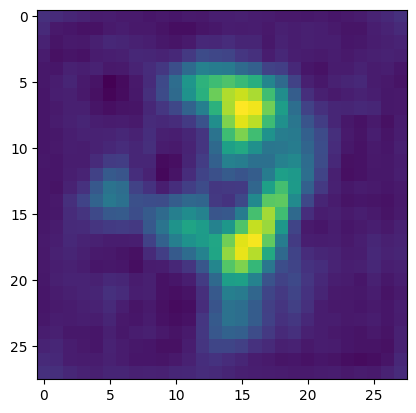

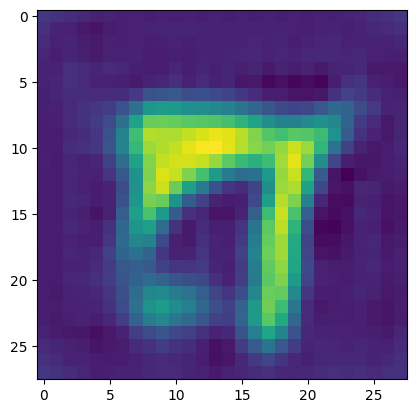

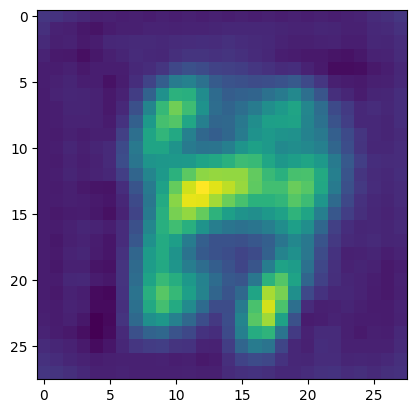

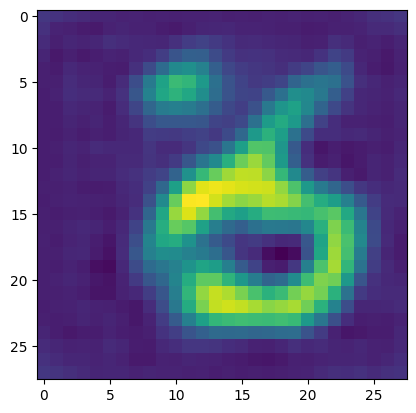

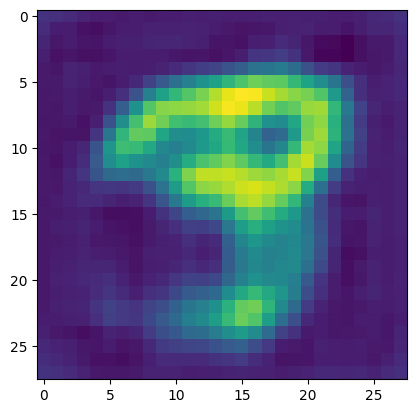

In [141]:
# class TempModel(nn.Module):
#     def __init__(self):
#         self.conv1 = nn.Conv2d(3, 5, (3, 3))
#     def forward(self, inp):
#         return self.conv1(inp)
# model = TempModel()
# model.load_state_dict(torch.load('conv_chkpt_conv_160.pth'))
model.eval()
with torch.no_grad():
    for _ in range(5):
        hidden = torch.normal(torch.zeros((1,1,7,7)), torch.ones((1,1,7,7))).to(device)

        plt.imshow(model.decoder(hidden).view(28, 28).cpu().detach().numpy())
        plt.show()